# Model training


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn - models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Boosting models
import xgboost as xgb
import lightgbm as lgb

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn

# Set random seed for reproducibility
RANDOM_STATE = 42

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)



## Load Transformed Data


In [4]:
# Setup MLflow tracking
mlflow.set_experiment("movie-rating-model-training")

# Load target variable (same for both pipeline versions)
y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()

print("Loading data...")
print(f"Train samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")


2026/01/01 21:18:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/01 21:18:41 INFO mlflow.store.db.utils: Updating database tables
2026/01/01 21:18:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/01 21:18:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/01 21:18:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/01 21:18:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Loading data...
Train samples: 7780
Test samples: 1946


## Discover Transformed Datasets


In [5]:
# Discover available transformed datasets
processed_dir = Path('../data/processed')
models_dir = Path('../models')

# Find all transformed dataset versions
transformed_files = list(processed_dir.glob('X_train_transformed_*.csv'))

AVAILABLE_DATASETS = {}
for train_file in transformed_files:
    version_key = train_file.stem.replace('X_train_transformed_', '')
    test_file = processed_dir / f'X_test_transformed_{version_key}.csv'
    
    if test_file.exists():
        AVAILABLE_DATASETS[version_key] = {
            'X_train_path': train_file,
            'X_test_path': test_file,
            'name': version_key.replace('_', ' ').title()
        }

print(f"Found {len(AVAILABLE_DATASETS)} transformed dataset version(s):")
for key, info in AVAILABLE_DATASETS.items():
    print(f"  - {info['name']} ({key})")


Found 2 transformed dataset version(s):
  - V1 (v1)
  - V2 (v2)


## Train Models with Transformed Data

Train models on pre-transformed data from each pipeline version.


In [6]:
# Define model configurations
def get_models():
    """Return models to train"""
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
        'Lasso': Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=5000),
        'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=5000),
        'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=RANDOM_STATE),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10,
                                               min_samples_leaf=4, random_state=RANDOM_STATE, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                                                        min_samples_split=10, random_state=RANDOM_STATE),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE, n_jobs=-1
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            num_leaves=31, subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
        )
    }
    
    return models



In [7]:
# Store results
all_results = []

# Get models
models = get_models()

# Train with each dataset version
for dataset_key, dataset_info in AVAILABLE_DATASETS.items():
    print(f"\n{'='*70}")
    print(f"Training with {dataset_info['name']} dataset ({dataset_key})")
    print(f"{'='*70}\n")
    
    # Load transformed data
    print(f"Loading transformed data from {dataset_info['name']}...")
    X_train_transformed = pd.read_csv(dataset_info['X_train_path'])
    X_test_transformed = pd.read_csv(dataset_info['X_test_path'])
    
    print(f"Transformed data loaded:")
    print(f"  Train: {X_train_transformed.shape}")
    print(f"  Test: {X_test_transformed.shape}")
    print(f"\nTraining {len(models)} models...\n")
    
    # Train each model on the transformed data
    for model_name, model in models.items():
        try:
            # Start MLflow run
            with mlflow.start_run(run_name=f"{dataset_key}_{model_name}"):
                # Log parameters
                mlflow.log_param("model_name", model_name)
                mlflow.log_param("dataset_version", dataset_key)
                mlflow.log_param("random_state", RANDOM_STATE)
                mlflow.log_param("n_features", X_train_transformed.shape[1])
                
                # Fit on transformed training data
                start_time = time.time()
                model.fit(X_train_transformed, y_train)
                training_time = time.time() - start_time
                
                # Predict on transformed training data
                y_train_pred = model.predict(X_train_transformed)
                train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
                train_mae = mean_absolute_error(y_train, y_train_pred)
                train_r2 = r2_score(y_train, y_train_pred)
                
                # Predict on transformed test data
                y_test_pred = model.predict(X_test_transformed)
                test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
                test_mae = mean_absolute_error(y_test, y_test_pred)
                test_r2 = r2_score(y_test, y_test_pred)
                
                # Cross-validation on transformed training data
                cv_scores = cross_val_score(
                    model, X_train_transformed, y_train,
                    cv=5,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1
                )
                cv_rmse = -cv_scores
                cv_rmse_mean = cv_rmse.mean()
                cv_rmse_std = cv_rmse.std()
                
                # Log metrics
                mlflow.log_metric("train_rmse", train_rmse)
                mlflow.log_metric("train_mae", train_mae)
                mlflow.log_metric("train_r2", train_r2)
                mlflow.log_metric("test_rmse", test_rmse)
                mlflow.log_metric("test_mae", test_mae)
                mlflow.log_metric("test_r2", test_r2)
                mlflow.log_metric("cv_rmse_mean", cv_rmse_mean)
                mlflow.log_metric("cv_rmse_std", cv_rmse_std)
                mlflow.log_metric("training_time", training_time)
                
                # Log the model
                mlflow.sklearn.log_model(
                    sk_model=model,
                    name="model"
                )
                
                # Store results
                all_results.append({
                    'dataset_version': dataset_key,
                    'model_name': model_name,
                    'train_rmse': train_rmse,
                    'train_mae': train_mae,
                    'train_r2': train_r2,
                    'test_rmse': test_rmse,
                    'test_mae': test_mae,
                    'test_r2': test_r2,
                    'cv_rmse_mean': cv_rmse_mean,
                    'cv_rmse_std': cv_rmse_std,
                    'training_time': training_time,
                    'n_features': X_train_transformed.shape[1],
                    'model': model  # Store trained model for later use
                })
                
                print(f"  ✓ {model_name:20s} | Test RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f} | R²: {test_r2:.4f} | Time: {training_time:.1f}s")
                
        except Exception as e:
            print(f"  ✗ {model_name:20s} | Error: {str(e)[:50]}")
            continue

print(f"\n{'='*70}")
print(f"Training complete! Trained {len(all_results)} models total.")
print(f"{'='*70}")




Training with V1 dataset (v1)

Loading transformed data from V1...
Transformed data loaded:
  Train: (7780, 119)
  Test: (1946, 119)

Training 9 models...



2026/01/01 21:20:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Linear Regression    | Test RMSE: 0.8505 | MAE: 0.6347 | R²: 0.1931 | Time: 0.0s


2026/01/01 21:20:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Ridge                | Test RMSE: 0.8504 | MAE: 0.6347 | R²: 0.1932 | Time: 0.0s


2026/01/01 21:20:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Lasso                | Test RMSE: 0.8540 | MAE: 0.6411 | R²: 0.1864 | Time: 0.0s


2026/01/01 21:20:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ ElasticNet           | Test RMSE: 0.8530 | MAE: 0.6389 | R²: 0.1883 | Time: 0.0s


2026/01/01 21:20:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Decision Tree        | Test RMSE: 0.8992 | MAE: 0.6602 | R²: 0.0981 | Time: 0.0s


2026/01/01 21:20:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Random Forest        | Test RMSE: 0.8462 | MAE: 0.6277 | R²: 0.2012 | Time: 0.4s


2026/01/01 21:21:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Gradient Boosting    | Test RMSE: 0.8503 | MAE: 0.6328 | R²: 0.1934 | Time: 2.3s


2026/01/01 21:21:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ XGBoost              | Test RMSE: 0.8504 | MAE: 0.6339 | R²: 0.1932 | Time: 0.3s


2026/01/01 21:21:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ LightGBM             | Test RMSE: 0.8408 | MAE: 0.6265 | R²: 0.2113 | Time: 0.4s

Training with V2 dataset (v2)

Loading transformed data from V2...
Transformed data loaded:
  Train: (7780, 807)
  Test: (1946, 807)

Training 9 models...



2026/01/01 21:21:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Linear Regression    | Test RMSE: 0.8664 | MAE: 0.6478 | R²: 0.1627 | Time: 0.4s


2026/01/01 21:21:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Ridge                | Test RMSE: 0.8520 | MAE: 0.6350 | R²: 0.1901 | Time: 0.1s


2026/01/01 21:21:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Lasso                | Test RMSE: 0.8540 | MAE: 0.6411 | R²: 0.1864 | Time: 0.1s


2026/01/01 21:21:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ ElasticNet           | Test RMSE: 0.8532 | MAE: 0.6391 | R²: 0.1878 | Time: 0.2s


2026/01/01 21:21:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Decision Tree        | Test RMSE: 0.9478 | MAE: 0.6944 | R²: -0.0022 | Time: 4.4s


2026/01/01 21:24:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Random Forest        | Test RMSE: 0.8457 | MAE: 0.6310 | R²: 0.2021 | Time: 38.3s


2026/01/01 21:32:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ Gradient Boosting    | Test RMSE: 0.8509 | MAE: 0.6311 | R²: 0.1922 | Time: 249.4s


2026/01/01 21:32:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ XGBoost              | Test RMSE: 0.8473 | MAE: 0.6314 | R²: 0.1991 | Time: 3.1s


2026/01/01 21:32:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


  ✓ LightGBM             | Test RMSE: 0.8440 | MAE: 0.6280 | R²: 0.2052 | Time: 1.5s

Training complete! Trained 18 models total.


In [10]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Dataset': r['dataset_version'],
        'Model': r['model_name'],
        'Train RMSE': r['train_rmse'],
        'Test RMSE': r['test_rmse'],
        'Train MAE': r['train_mae'],
        'Test MAE': r['test_mae'],
        'Train R²': r['train_r2'],
        'Test R²': r['test_r2'],
        'CV RMSE': r['cv_rmse_mean'],
        'CV Std': r['cv_rmse_std'],
        'Time (s)': r['training_time'],
        'Features': r['n_features']
    }
    for r in all_results
])

# Sort by test RMSE
comparison_df = comparison_df.sort_values('Test RMSE')

# Save to file
comparison_df.to_csv(models_dir / 'model_comparison_all_datasets.csv', index=False)

print("\n" + "="*100)
print("MODEL COMPARISON (sorted by Test RMSE)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

print(f"\nResults saved to: {models_dir / 'model_comparison_all_datasets.csv'}")




MODEL COMPARISON (sorted by Test RMSE)
Dataset             Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²   Test R²  CV RMSE   CV Std   Time (s)  Features
     v1          LightGBM    0.741427   0.840820   0.560860  0.626456  0.352596  0.211297 0.811310 0.026042   0.407266       119
     v2          LightGBM    0.485894   0.844043   0.373894  0.628000  0.721951  0.205239 0.813649 0.029344   1.497109       807
     v2     Random Forest    0.522984   0.845712   0.383221  0.630982  0.677882  0.202094 0.818416 0.028079  38.257499       807
     v1     Random Forest    0.708317   0.846210   0.536382  0.627660  0.409127  0.201153 0.811468 0.024992   0.394899       119
     v2           XGBoost    0.424553   0.847321   0.332114  0.631408  0.787723  0.199055 0.822176 0.027740   3.056125       807
     v1 Gradient Boosting    0.711018   0.850321   0.550677  0.632757  0.404613  0.193372 0.818239 0.020479   2.327340       119
     v1           XGBoost    0.682025   0.850387   0.5237

## Results Comparison


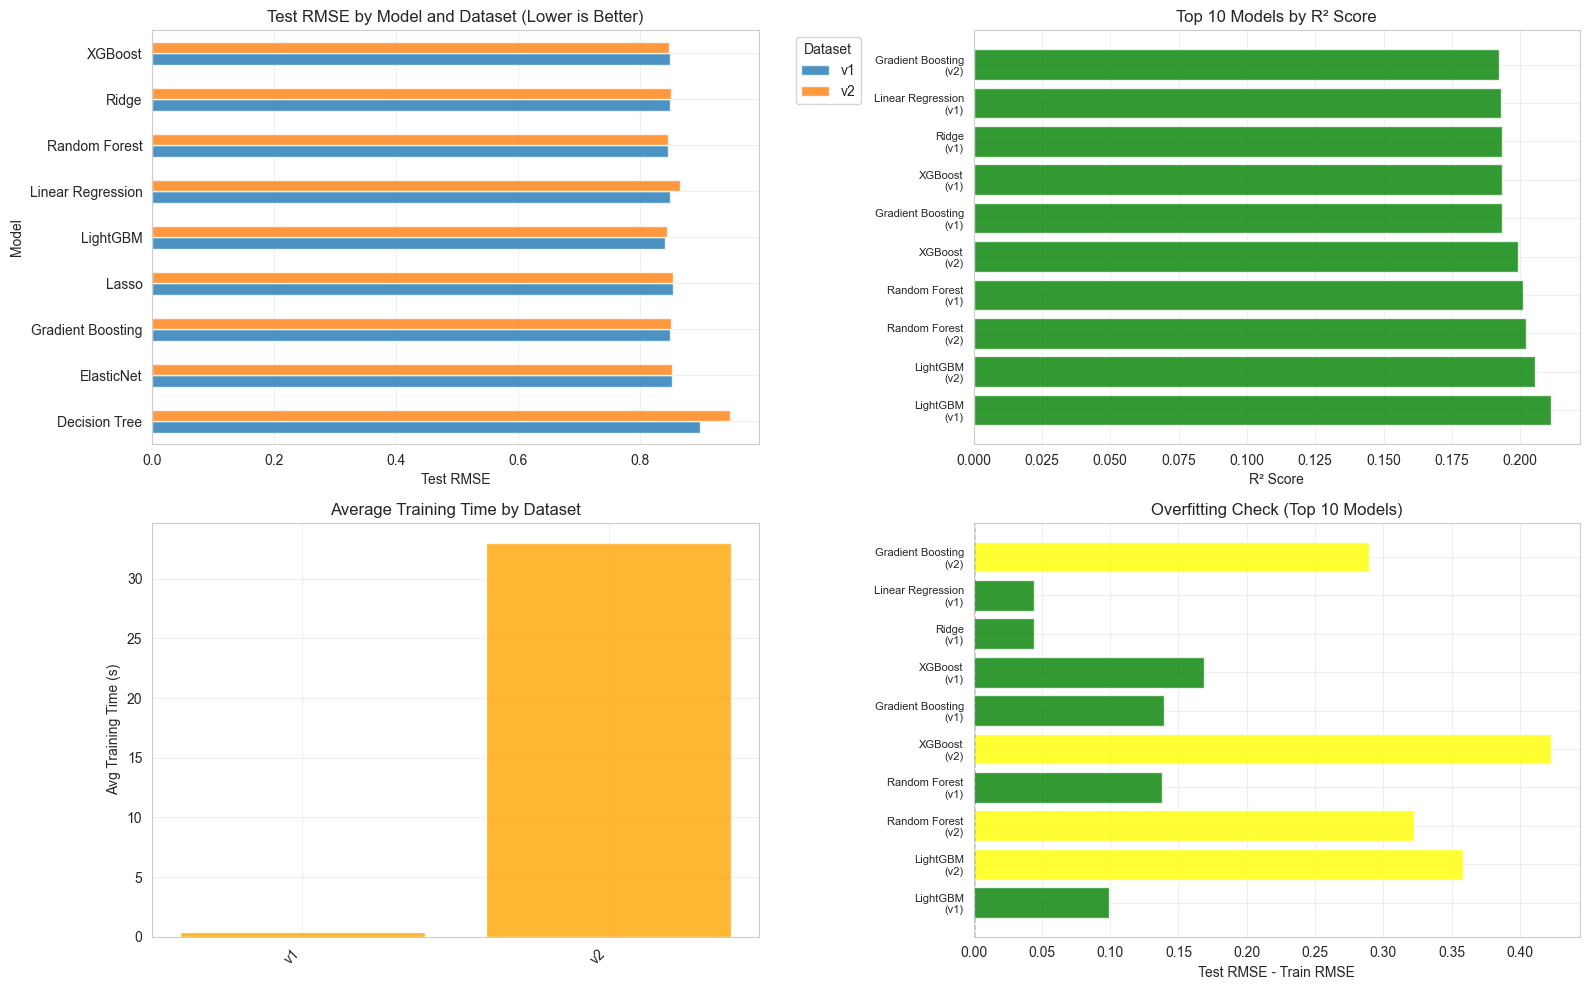

In [15]:
# Visualize results across datasets
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. RMSE by Dataset and Model
if len(AVAILABLE_DATASETS) > 1:
    pivot_rmse = comparison_df.pivot_table(
        values='Test RMSE', 
        index='Model', 
        columns='Dataset', 
        aggfunc='first'
    )
    pivot_rmse.plot(kind='barh', ax=axes[0, 0], alpha=0.8)
    axes[0, 0].set_xlabel('Test RMSE')
    axes[0, 0].set_title('Test RMSE by Model and Dataset (Lower is Better)')
    axes[0, 0].legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
else:
    # Single dataset - just show models
    comparison_df.plot(x='Model', y='Test RMSE', kind='barh', ax=axes[0, 0], alpha=0.8, legend=False)
    axes[0, 0].set_xlabel('Test RMSE')
    axes[0, 0].set_title('Test RMSE by Model (Lower is Better)')
    axes[0, 0].grid(True, alpha=0.3)

# 2. R² Score comparison (top 10)
top_10 = comparison_df.head(10)
x = np.arange(len(top_10))
axes[0, 1].barh(x, top_10['Test R²'], alpha=0.8, color='green')
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels([f"{row['Model']}\n({row['Dataset']})" 
                             for _, row in top_10.iterrows()], fontsize=8)
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Top 10 Models by R² Score')
axes[0, 1].grid(True, alpha=0.3)

# 3. Training time by dataset
if len(AVAILABLE_DATASETS) > 1:
    dataset_times = comparison_df.groupby('Dataset')['Time (s)'].mean()
    axes[1, 0].bar(range(len(dataset_times)), dataset_times.values, alpha=0.8, color='orange')
    axes[1, 0].set_xticks(range(len(dataset_times)))
    axes[1, 0].set_xticklabels(dataset_times.index, rotation=45, ha='right')
    axes[1, 0].set_ylabel('Avg Training Time (s)')
    axes[1, 0].set_title('Average Training Time by Dataset')
    axes[1, 0].grid(True, alpha=0.3)
else:
    # Single dataset - show by model
    axes[1, 0].barh(comparison_df['Model'], comparison_df['Time (s)'], alpha=0.8, color='orange')
    axes[1, 0].set_xlabel('Training Time (s)')
    axes[1, 0].set_title('Training Time by Model')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Overfitting check (top 10 models)
overfit = top_10['Test RMSE'] - top_10['Train RMSE']
colors = ['red' if x > 0.5 else 'yellow' if x > 0.2 else 'green' for x in overfit]
axes[1, 1].barh(x, overfit, alpha=0.8, color=colors)
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels([f"{row['Model']}\n({row['Dataset']})" 
                             for _, row in top_10.iterrows()], fontsize=8)
axes[1, 1].set_xlabel('Test RMSE - Train RMSE')
axes[1, 1].set_title('Overfitting Check (Top 10 Models)')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Get overall best model
best_result = min(all_results, key=lambda x: x['test_rmse'])

print(f"\n{'='*70}")
print("BEST MODEL OVERALL")
print(f"{'='*70}")
print(f"\nDataset: {best_result['dataset_version']}")
print(f"Model: {best_result['model_name']}")
print(f"Test RMSE: {best_result['test_rmse']:.4f}")
print(f"Test MAE: {best_result['test_mae']:.4f}")
print(f"Test R²: {best_result['test_r2']:.4f}")
print(f"CV RMSE: {best_result['cv_rmse_mean']:.4f} ± {best_result['cv_rmse_std']:.4f}")
print(f"Training Time: {best_result['training_time']:.2f}s")
print(f"Features: {best_result['n_features']}")

# Save best model
best_model_path = models_dir / 'best_model.pkl'

import pickle
with open(best_model_path, 'wb') as f:
    pickle.dump(best_result['model'], f)

# Save metadata
metadata = {
    'dataset_version': best_result['dataset_version'],
    'model_name': best_result['model_name'],
    'test_rmse': best_result['test_rmse'],
    'test_mae': best_result['test_mae'],
    'test_r2': best_result['test_r2'],
    'cv_rmse': best_result['cv_rmse_mean'],
    'cv_rmse_std': best_result['cv_rmse_std'],
    'training_time': best_result['training_time'],
    'n_features': best_result['n_features']
}

with open(models_dir / 'best_model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(f"\nBest model saved to: {best_model_path}")
print(f"Metadata saved to: {models_dir / 'best_model_metadata.pkl'}")
print(f"\nThe model predicts ratings with avg error of {best_result['test_mae']:.2f} points.")
print("="*70)




BEST MODEL OVERALL

Dataset: v1
Model: LightGBM
Test RMSE: 0.8408
Test MAE: 0.6265
Test R²: 0.2113
CV RMSE: 0.8113 ± 0.0260
Training Time: 0.41s
Features: 119

est model saved to: ../models/best_model.pkl
Metadata saved to: ../models/best_model_metadata.pkl

The model predicts ratings with avg error of 0.63 points.
